In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection


In [2]:
df = pd.read_csv("../CSVs/daily_revenue.csv", index_col="date", dayfirst=True, parse_dates=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [3]:
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df = df.asfreq('D')
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [4]:
# Transform regressors to float
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float) 
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype(float)

df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90


In [5]:
#Splitting the data into training and testing sets
periods = 30
train, test = df.iloc[:-periods], df.iloc[-periods:]
exog_train, exog_test = df.iloc[:-periods, 1:3], df.iloc[-periods:, 1:3]

test.head(), exog_test.head()

(               revenue  discount_rate  coupon_rate
 date                                              
 2022-11-01  16703680.0          23.85         1.50
 2022-11-02  15827022.0          20.76         0.94
 2022-11-03  16154319.0          21.85         0.92
 2022-11-04  14707212.0          20.17         0.88
 2022-11-05  14877530.0          17.85         0.41,
             discount_rate  coupon_rate
 date                                  
 2022-11-01          23.85         1.50
 2022-11-02          20.76         0.94
 2022-11-03          21.85         0.92
 2022-11-04          20.17         0.88
 2022-11-05          17.85         0.41)

In [6]:
# Using pmdarima to find the best SARIMA model and best parameters
model = auto_arima(train['revenue'], m=7, X = exog_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Sat, 21 Jun 2025   AIC                          57250.045
Time:                                   17:53:16   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.634      2.082      0.037     961.041    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.155      0.000    8.04e+05    1.04e+06
ar.L1            -0.6529      0.155     -4.206      0.000      -0.957      -0.349
ar.L2             0.1830      0.048      3.776      0.000       0.088       0.278
ma.L1             0.1070      0.154      0.692      0.489      -0.196       0.410
ma.L2            -0.6926      0.124     -5.579      0.000      -0.936      -0.449
ar.S.L7           0.0523      0.187      0.279      0.780      -0.314       0.419
ar.S.L14          0.9000      0.178      5.065      0.000       0.552       1.248
ma.S.L7           0.0183      0.183      0.100      0.920      -0.339       0.376
ma.S.L14         -0.8501      0.161     -5.290      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.81e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075241.23
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+29. Standard errors may be unstable.
"""

In [7]:
# Prediciton using the best ARIMA model
predictions = model.predict(n_periods=periods, X=exog_test)
predictions

2022-11-01    1.675208e+07
2022-11-02    1.494552e+07
2022-11-03    1.488439e+07
2022-11-04    1.296422e+07
2022-11-05    1.205477e+07
2022-11-06    1.394982e+07
2022-11-07    1.341740e+07
2022-11-08    1.328255e+07
2022-11-09    1.441188e+07
2022-11-10    2.077588e+07
2022-11-11    2.121857e+07
2022-11-12    1.346326e+07
2022-11-13    1.489120e+07
2022-11-14    1.299923e+07
2022-11-15    1.348081e+07
2022-11-16    1.398039e+07
2022-11-17    1.803906e+07
2022-11-18    1.675113e+07
2022-11-19    1.712319e+07
2022-11-20    1.980787e+07
2022-11-21    1.847905e+07
2022-11-22    1.908228e+07
2022-11-23    1.913629e+07
2022-11-24    2.068908e+07
2022-11-25    1.926290e+07
2022-11-26    1.851270e+07
2022-11-27    2.073235e+07
2022-11-28    2.607977e+07
2022-11-29    1.588268e+07
2022-11-30    1.479939e+07
Freq: D, dtype: float64

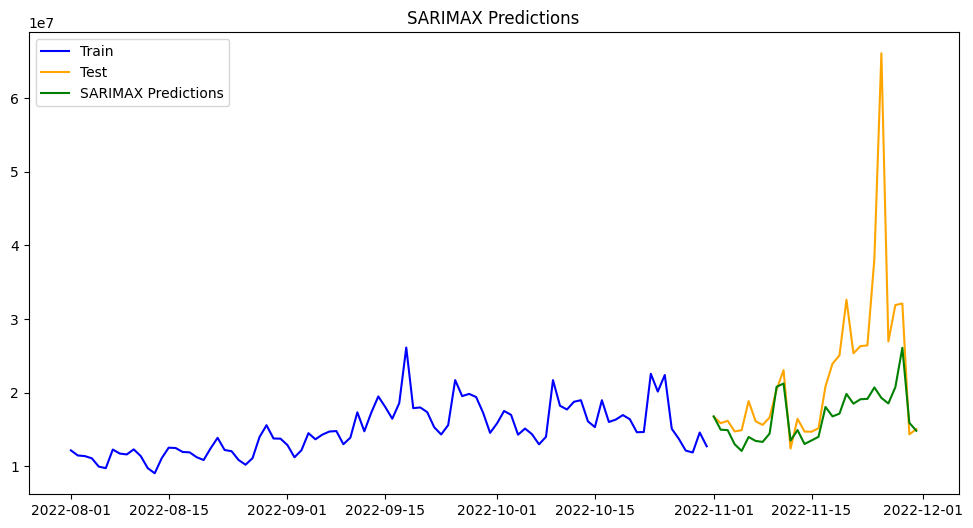

Mean Absolute Error (MAE) for SARIMAX: 5716515.56
Root Mean Squared Error (RMSE) for SARIMAX: 10394588.03
Mean Absolute Percentage Error (MAPE) for SARIMAX: 19.36%


In [8]:
def assess_model(train, test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Test', color='orange')
    plt.plot(predictions, label=f'{model_name} Predictions', color='green')
    plt.title(f'{model_name} Predictions')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, predictions)
    print(f'Mean Absolute Error (MAE) for {model_name}: {mae:.2f}')
    rmse = mean_squared_error(test, predictions)  
    rmse = rmse ** 0.5
    print(f'Root Mean Squared Error (RMSE) for {model_name}: {rmse:.2f}')
    mape = mean_absolute_percentage_error(test, predictions)        
    print(f'Mean Absolute Percentage Error (MAPE) for {model_name}: {mape:.2%}') 


assess_model(train['revenue']['2022-08':], test['revenue']['2022-08':], predictions, 'SARIMAX')